In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable
np.random.seed(420420)

### Integrate and Fire Model (with input noise)
$$
\begin{align}
\tau_m \dot u &= -(u + u_{rest}) + RI + \sigma \eta\\
u &\rightarrow u_{r}, &u > \theta \\
\text{By Euler's method:} \\
\tau_m \frac{u(t+\Delta t) - u(t)}{\Delta t} &= -u(t) + u_{rest} + RI(t) + \sigma \eta(t)\\
\Longrightarrow u(t+\Delta t) &= u(t) + \frac{\Delta t}{\tau_m} (-u(t) + u_{rest} + RI(t) + \sigma \eta(t))\\
u(0) &= u_{rest} \\
\text{Which is refactored for optimisation into:} \\
u(t+\Delta t) &= \overbrace{(1 - \frac{\Delta t}{\tau_m})}^\alpha u(t) + \overbrace{\frac{\Delta t}{\tau_m}(u_{rest} + RI(t) + \sigma \eta(t))}^\beta
\end{align}
$$
$$\begin{align}
\text{Where $\beta$ can be precomputed if the current is indpendent of the neurons' output} 
\end{align}
$$

In [2]:
@dataclass
class Neuron:
    tau_m : np.float32 = 10  # ms ~ time constant (R * C)
    R     : np.float32 = 1   # MO ~ resistance
    theta : np.float32 = -55 # mV ~ threshold potential
    u_rest: np.float32 = -65 # mV ~ resting potential
    u_r   : np.float32 = -70 # mV ~ reset potential
    u_0   : np.float32 = u_rest # ~ initial potential
    I     : Callable[[np.float32], np.float32] = lambda t: np.float32(9) # ms -> nA ~ Current  
    sigma : np.float32 = 0   # mV ~ noise standard deviation

    def __post_init__(self):
        if callable(self.I): self.I = [self.I]
        assert all(callable(f) for f in self.I), "I entries must be functions of time!"

    def vectorize_I(self, ts):
        return np.array([
            np.full_like(ts, f(ts)) if np.isscalar(f(ts)) else f(ts) 
            for f in self.I]).T
    
    def set_get_timeseries(self, T=None, dt=None, T0=0):
        if T is None or dt is None:
            assert hasattr(self,"_dt"), "Timeseries was not previously set!"
            return self._ts, self._us, self._Is, self._dt
        self._dt = dt
        self._ts = np.linspace(T0, T, int((T-T0)/dt)) # T,
        self._Is = self.vectorize_I(self._ts)         # T, I
        self._us = np.full_like(self._Is, self.u_0)   # T, I
        return self._ts, self._us, self._Is, self._dt
    
    def euler_run(self, T=None, dt=None, T0=0):
        ts, us, Is, dt = self.set_get_timeseries(T=T, dt=dt, T0=T0)
        noise = np.random.normal(0, self.sigma, size=Is.shape)
        beta = (1 - dt / self.tau_m)
        alpha = dt / self.tau_m * (self.u_rest + self.R * Is + noise)
            
        for i in range(1, len(self._ts)):
            us[i] = beta * us[i-1] + alpha[i-1] 
            us[i] = np.where(us[i] < self.theta, us[i], self.u_r)

        return ts, us, Is

    def analytic_firing_frequency_constant_current(self, I0):
        nonzero = I0 > ((self.theta - self.u_rest) / self.R)
        with np.errstate(divide="ignore", invalid="ignore"):
            result = 1 / (-self.tau_m * np.log(1 - (self.theta - self.u_rest) / (self.R * I0)))
        return np.where(nonzero, result, 0.0)

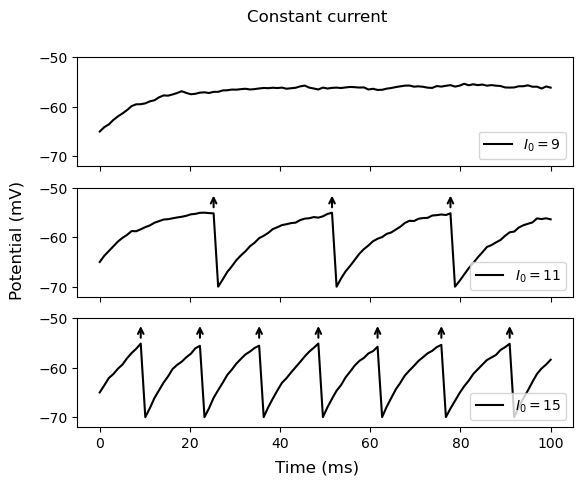

In [3]:
I0s = [9, 11, 15]
n = Neuron(I=[(lambda t, I0=I0: I0) for I0 in I0s], sigma=2)
ts, uss, *_ = n.euler_run(T=100, dt=1)

fig, axs = plt.subplots(len(I0s), 1, sharex=True, sharey=True)

for us, ax, I0 in zip(uss.T, axs, I0s): 
    ax.plot(ts, us, color="black", label=f"$I_0 = {I0}$")
    ax.legend(loc=4)
    ax.set_ylim(top=n.theta + 5, bottom=min(us)-2)
    
    for t in ts[:-1][(us == n.u_r)[1:]]:
        ax.annotate('', xy=(t, n.theta + 0.5), xytext=(t, n.theta + 4),
                    arrowprops=dict(color="black", arrowstyle='<-', lw=1.5))

fig.suptitle("Constant current")
fig.supxlabel("Time (ms)")
fig.supylabel("Potential (mV)")
plt.show()

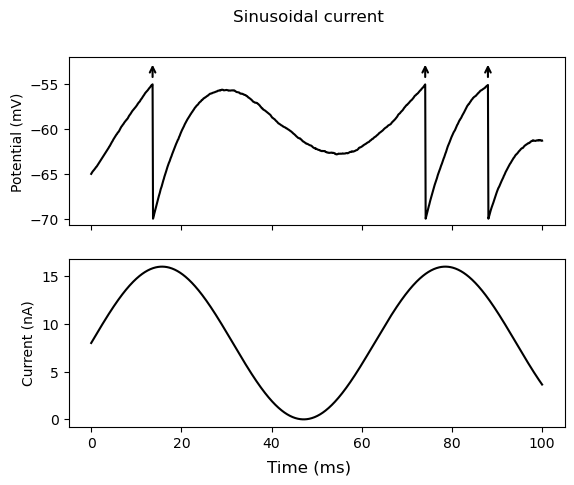

In [4]:
n = Neuron(I=lambda t: np.sin(0.1*t) * 8 + 8, sigma=2)
ts, us, Is = n.euler_run(T=100, dt=0.1)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ts, us, color="black")
axs[0].set_ylabel("Potential (mV)")
axs[0].set_ylim(top=n.theta + 3) 

for t in ts[:-1][(us[:,0] == n.u_r)[1:]]:
    axs[0].annotate('', xy=(t, n.theta + 0.5), xytext=(t, n.theta + 2.5),
                    arrowprops=dict(color='black', arrowstyle='<-', lw=1.5))

axs[1].plot(ts, Is, color="black")
axs[1].set_ylabel("Current (nA)")

fig.suptitle("Sinusoidal current")
fig.supxlabel("Time (ms)")
plt.show()

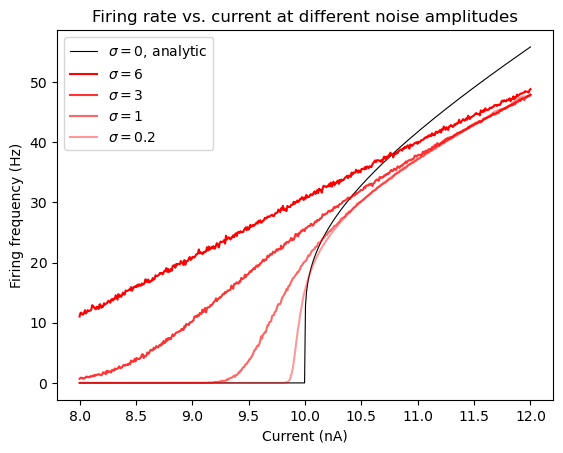

CPU times: user 8.41 s, sys: 626 ms, total: 9.03 s
Wall time: 9.03 s


In [5]:
%%time
I0s = np.linspace(8, 12, 500)
n = Neuron(I=[(lambda t, I0=I0: I0) for I0 in I0s])
T, dt = 100_000, 1
n.set_get_timeseries(T=T, dt=dt)
plt.plot(I0s, n.analytic_firing_frequency_constant_current(I0s) * 1000, 
         linewidth=0.8, color="black", label=r"$\sigma = 0$, analytic")

for i, sigma in list(enumerate([0.2,1,3,6][::-1])):
    n.sigma = sigma
    ts, us, _ = n.euler_run()
    ffs = (us == n.u_r).sum(axis=0) / T * 1000
    plt.plot(I0s, ffs, color="red", alpha=1-i*0.2, label=r"$\sigma "f"= {sigma}$")

plt.legend()
plt.title("Firing rate vs. current at different noise amplitudes")
plt.ylabel("Firing frequency (Hz)")
plt.xlabel("Current (nA)")
plt.show()